In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
from statsmodels.api import OLS, add_constant

from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler

# Load Data

In [61]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df['day'] = pd.DatetimeIndex(train_df['date']).day
test_df['day'] = pd.DatetimeIndex(test_df['date']).day

display(train_df.head(5))
display(test_df.head(5))

,id,date,season_id,year,month,is_holiday,weekday,is_workingday,weather_condition,temperature,feels_like_temp,humidity,wind_speed,total_users,day
0,577,31-07-2019,3,1,7,0,2,1,1,29.246653,33.1448,70.4167,11.083475,7216,31
1,427,03-03-2019,1,1,3,0,6,0,2,16.980847,20.6746,62.1250,10.792293,4066,3
2,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.5850,48.3333,23.500518,1796,30
3,483,28-04-2019,2,1,4,0,6,0,2,15.443347,18.8752,48.9583,8.708325,4220,28
4,112,22-04-2018,2,0,4,0,5,1,2,13.803347,16.0977,72.9583,14.707907,1683,22


,id,date,season_id,year,month,is_holiday,weekday,is_workingday,weather_condition,temperature,feels_like_temp,humidity,wind_speed,day
0,1,04-07-2018,3,0,7,1,1,0,2,29.793347,33.27085,63.7917,5.459106,7
1,2,20-06-2019,2,1,6,0,3,1,1,32.082500,36.04875,59.2083,7.625404,20
2,3,27-10-2018,4,0,10,0,4,1,2,19.270000,22.85230,81.2917,13.250121,27
3,4,10-08-2018,3,0,8,0,3,1,1,31.433347,34.24915,42.4167,13.417286,8
4,5,02-06-2018,2,0,6,0,4,1,1,29.315000,32.19710,30.5000,19.583229,6


# Data Analysis

## Missing Data

There are no missing values in data to handle.

In [62]:
display(train_df.isnull().sum())

id                   0
date                 0
season_id            0
year                 0
month                0
is_holiday           0
weekday              0
is_workingday        0
weather_condition    0
temperature          0
feels_like_temp      0
humidity             0
wind_speed           0
total_users          0
day                  0
dtype: int64

## Total User Distribution

We can see that total user distribution is like normal distibution.

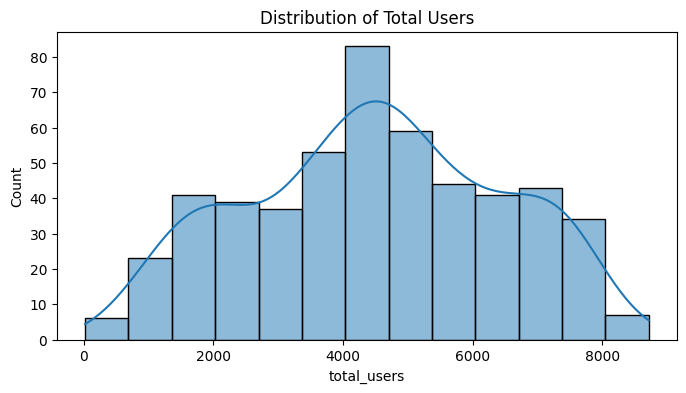

In [63]:
plt.figure(figsize=(8, 4))
sns.histplot(train_df['total_users'], kde=True)
plt.title('Distribution of Total Users')
plt.show()

## Features Correlation

Another aspect that can show us how features are related, is correlation. here we have the table of correlation between each two feature. It can be seen that *feels_like_temp* and *temperature* are highly correlated with *total_users*. also these two features are highly correlated with eachother too. *wind* and *humidity* are negaively correlated with *total_users*. we can consider these facts in our feauture selection part. 

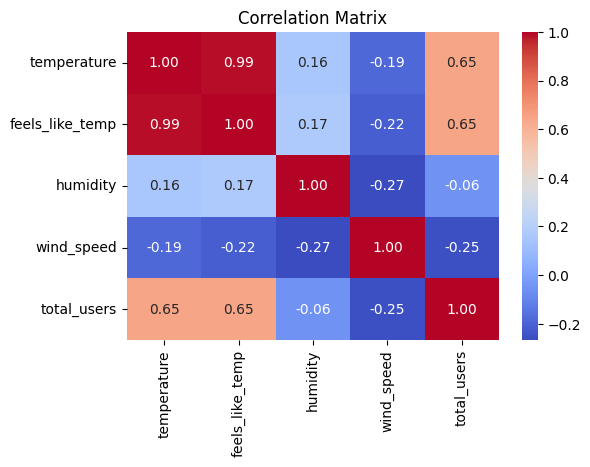

In [64]:
plt.figure(figsize=(6, 4))
numeric_cols = ["temperature", "feels_like_temp", "humidity", "wind_speed", "total_users"]
numeric_df = train_df[numeric_cols]
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Scatter Plots

Here are some scatter plots betweeen numeric columns and *total_users*. We can see some negative and positive correlations in this plots.

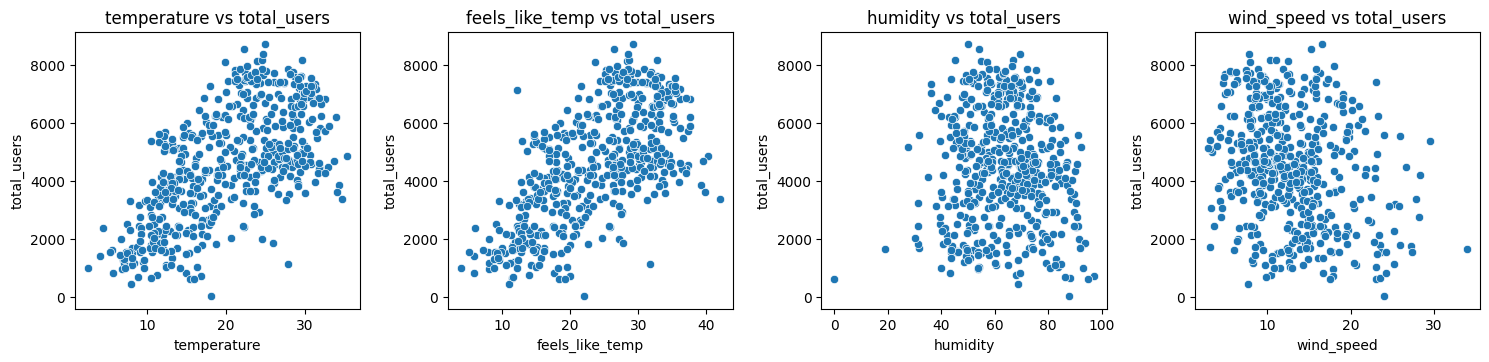

In [65]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_cols): 
    if feature != "total_users":
        plt.subplot(3, 4, i+1)
        sns.scatterplot(x=feature, y='total_users', data=train_df)
        plt.title(f'{feature} vs total_users')
plt.tight_layout()
plt.show()

## Box Plots

We can have a summarized info about categorical features and *total_users*. For instance, we can see that in third season there are more rentings. In non-holidays, there are mostly more users. And in weather conditions, there are more users in 1 then 2 then 3.  

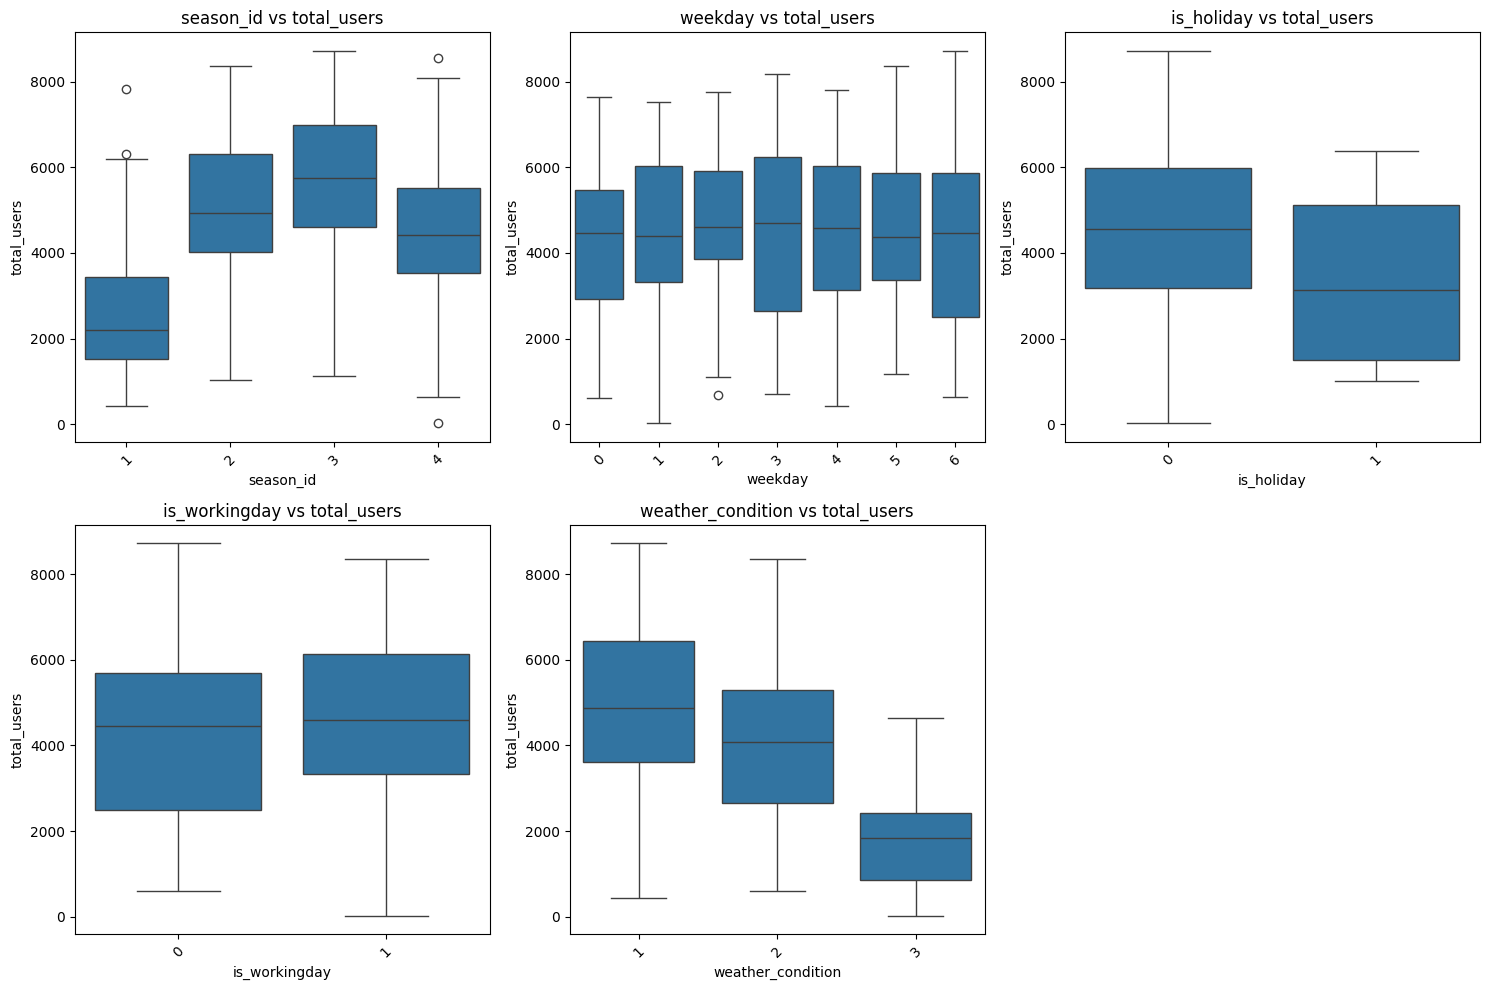

In [66]:
cat_cols = ["season_id", "weekday", "is_holiday", "is_workingday", "weather_condition"]

plt.figure(figsize=(15, 10))
i = 0
for feature in cat_cols: 
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=feature, y='total_users', data=train_df)
    plt.title(f'{feature} vs total_users')
    plt.xticks(rotation=45)
    i += 1
plt.tight_layout()
plt.show()

## Day vs Total_users

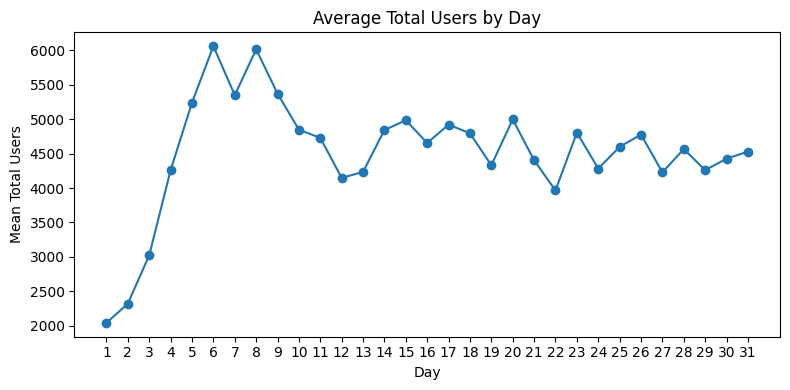

In [67]:
mean_by_day = train_df.groupby('day')['total_users'].mean().reset_index()
mean_by_day = mean_by_day.sort_values('day')

plt.figure(figsize=(8,4))
plt.plot(mean_by_day['day'], mean_by_day['total_users'], marker='o')
plt.xlabel('Day')
plt.ylabel('Mean Total Users')
plt.title('Average Total Users by Day')
plt.xticks(mean_by_day['day']) 
plt.tight_layout()
plt.show()

# Training Model

# Rolling

At first i tried adding rolling features to dataset. but it didnt workout and results got much worse.

In [68]:
test_df['date'] = pd.to_datetime(test_df['date'], dayfirst=True, errors='coerce')
train_df['date'] = pd.to_datetime(train_df['date'], dayfirst=True, errors='coerce')

# test_df = test_df.copy()
# test_df['total_users'] = np.nan

# full = pd.concat([train_df, test_df], ignore_index=True, sort=False)
# full = full.sort_values('date').reset_index(drop=True)

# full['total_users'] = full['total_users'].astype(float)

# full['roll7']  = full['total_users'].rolling(window=7, min_periods=1).mean().shift(1)
# full['roll30'] = full['total_users'].rolling(window=30, min_periods=1).mean().shift(1)

# full['roll7'].fillna(full['roll7'].mean(), inplace=True)
# full['roll30'].fillna(full['roll30'].mean(), inplace=True)

# display(full)

# train_df = full.loc[full['total_users'].notna()].copy()  
# test_df  = full.loc[full['total_users'].isna()].copy() 


At first we extract the *day* from date and then remove the date column because we wont use this directly in our analysis. As long as *feels_like_temp* is highly correlated with *temp* we remove the temperature columns.

In [69]:
train_df['day'] = pd.DatetimeIndex(train_df['date']).day
test_df['day'] = pd.DatetimeIndex(test_df['date']).day

train_df.drop(columns=["date", "id", "feels_like_temp"], inplace=True)
test_ids = test_df["id"]
test_df.drop(columns=["date", "id", "feels_like_temp"], inplace=True)

Then we seperate the observe data (X) from prediction data(y) :

In [70]:
X = train_df.drop(columns=["total_users"])
y = train_df["total_users"]

## P-values for Feauture Selection

Here we can see the p-values of features. By testing different feature selection, I saw that not removing any feature regardless of its p-value, gives much more accurate model.

In [71]:
F, pvals = f_regression(X, y, center=True)
pvals_series = pd.Series(pvals, index=X.columns).sort_values()
print(pvals_series)

temperature          2.456845e-61
year                 1.952064e-49
season_id            5.502948e-19
weather_condition    3.758238e-11
month                7.275769e-11
wind_speed           6.834219e-09
is_holiday           3.027393e-02
is_workingday        3.776445e-02
humidity             1.849633e-01
weekday              4.649932e-01
day                  6.519638e-01
dtype: float64


In [72]:
selected_features = ['temperature', 'year', 'season_id', 'weather_condition',
 'month', 'wind_speed', 'is_holiday', 'is_workingday', 'humidity', 'day', 'weekday']

# X = X[selected_features]
# test_df = test_df[selected_features]

## Scale and Encode

Here we encode the categorical features(one-hot encode) and standardize the numeric features.

In [73]:
def prepare_df(df, categorical_cols, numerical_cols, scaler=None):
    df[categorical_cols] = df[categorical_cols].astype(str)
    df_cat = pd.get_dummies(df[categorical_cols], drop_first=False)

    if scaler is None:
        scaler = StandardScaler().fit(df[numerical_cols])
    df_num = pd.DataFrame(
        scaler.transform(df[numerical_cols]),
        columns=numerical_cols,
        index=df.index
    )
    
    df_prep = pd.concat([df_num, df_cat], axis=1)
    return df_prep, scaler

In [74]:
categorical_features = X.select_dtypes(include=["object", "category", "bool", "int64"]).columns.tolist()
display(categorical_features)
numerical_features = X.select_dtypes(include=["float64", "int64"]).columns.difference(categorical_features).tolist()
display(numerical_features)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
categorical_features = X.select_dtypes(include=["object", "category", "bool", "int64"]).columns.tolist()
numerical_features = X.select_dtypes(include=["float64", "int64"]).columns.difference(categorical_features).tolist()
X_train, _ = prepare_df(X_train, categorical_features, numerical_features)
X_valid, _ = prepare_df(X_valid, categorical_features, numerical_features, _)

['season_id',
 'year',
 'month',
 'is_holiday',
 'weekday',
 'is_workingday',
 'weather_condition']

['humidity', 'temperature', 'wind_speed']

In [75]:
X_train

,humidity,temperature,wind_speed,season_id_1,season_id_2,season_id_3,season_id_4,year_0,year_1,month_1,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,is_workingday_0,is_workingday_1,weather_condition_1,weather_condition_2,weather_condition_3
23,-0.402709,-0.761102,1.426549,False,False,False,True,True,False,False,...,False,False,True,False,False,False,True,False,True,False
231,0.136969,1.627596,1.240778,False,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
265,0.450799,1.185243,0.305147,False,True,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
208,2.218901,-0.566346,1.898095,True,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,False
5,-0.138737,1.762626,0.830928,False,False,True,False,False,True,False,...,False,False,False,False,True,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-1.585350,-1.076522,0.405412,True,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
270,-1.537786,-2.069533,-0.073718,True,False,False,False,False,True,True,...,False,True,False,False,False,False,True,False,True,False
348,-0.370441,-0.770417,-1.712835,False,False,False,True,False,True,False,...,False,False,True,False,False,True,False,True,False,False
435,0.796897,0.877925,-0.437091,False,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False


In [76]:
F, pvals = f_regression(X_train, y_train, center=True)
pvals_series = pd.Series(pvals, index=X_train.columns).sort_values()
print(pvals_series)

alpha = 0.25

significant_features = pvals_series[pvals_series <= alpha].index

# X_train = X_train[significant_features]
# X_valid = X_valid[significant_features]

temperature            4.429158e-52
year_0                 2.291934e-36
year_1                 2.291934e-36
season_id_1            1.580723e-29
season_id_3            1.092313e-15
month_1                1.616131e-13
wind_speed             8.225867e-09
month_2                2.658225e-08
weather_condition_1    2.339886e-07
month_8                3.186566e-07
weather_condition_3    1.546721e-06
month_9                6.244668e-06
month_6                8.975178e-05
weather_condition_2    4.968119e-04
month_7                2.274897e-03
month_3                8.522190e-03
season_id_2            1.224323e-02
month_12               1.494462e-02
month_5                2.368376e-02
is_workingday_1        1.005280e-01
is_workingday_0        1.005280e-01
is_holiday_0           1.258337e-01
is_holiday_1           1.258337e-01
weekday_0              1.713799e-01
humidity               2.238135e-01
month_10               2.783409e-01
month_11               2.843854e-01
weekday_3              3.773

## Finding the best Model

We test different models and find best of them according to the lowest RMSE:

In [77]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid, y_pred)
    mae = mean_absolute_error(y_valid, y_pred)
    
    results[name] = {
        'model': model,
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae
    }
    
    print(f"\n{name} Results:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
print(f"\nBest Model: {best_model_name} with RMSE: {results[best_model_name]['RMSE']:.2f}")


Linear Regression Results:
MSE: 698831.50
RMSE: 835.96
R2: 0.7595
MAE: 596.38

Ridge Regression Results:
MSE: 681006.23
RMSE: 825.23
R2: 0.7656
MAE: 586.71

Lasso Regression Results:
MSE: 688719.99
RMSE: 829.89
R2: 0.7630
MAE: 591.38

Decision Tree Results:
MSE: 1043168.96
RMSE: 1021.36
R2: 0.6410
MAE: 702.36

Random Forest Results:
MSE: 631677.51
RMSE: 794.78
R2: 0.7826
MAE: 539.52

Gradient Boosting Results:
MSE: 550406.65
RMSE: 741.89
R2: 0.8106
MAE: 501.80

Best Model: Gradient Boosting with RMSE: 741.89


## Finding the best parameters for best model

Now when the best model is found, we search for the best possible values for its arguments.

In [78]:
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
    'Lasso Regression': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
    'Decision Tree': {'max_depth': [None, 5, 10, 15, 20], 
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4]},
    'Random Forest': {'n_estimators': [100, 200, 300],
                        'max_depth': [None, 10, 20, 30],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4]},
    'Gradient Boosting': {'n_estimators': [100, 200, 300, 350],
                            'learning_rate': [0.01, 0.1, 0.2],
                            'max_depth': [3, 5, 7],
                            'subsample': [0.55, 0.6, 0.7, 0.8, 0.9, 1.0]}
}

model_classes = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

if param_grids[best_model_name]:
    print(f"\nTuning hyperparameters for {best_model_name}...")
    grid_search = GridSearchCV(
        estimator=model_classes[best_model_name],
        param_grid=param_grids[best_model_name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best MSE: {-grid_search.best_score_:.2f}")
    
    model = grid_search.best_estimator_
else:
    model = model_classes[best_model_name].fit(X_train, y_train)


Tuning hyperparameters for Gradient Boosting...
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 350, 'subsample': 0.9}
Best MSE: 393989.09


# Test Data

Here we use all the data for training our model to predict the result for test data: 

In [79]:
X, _ = prepare_df(X, categorical_features, numerical_features)
test_df, _ = prepare_df(test_df, categorical_features, numerical_features, _)

# X = X[significant_features]
# test_df = test_df[significant_features]

model.fit(X, y)
test_preds = model.predict(test_df)
submission = pd.DataFrame({'id': range(1, len(test_preds) + 1),'label': test_preds.round(0).astype(int)})
submission.to_csv('submission.csv', index=False)
model

GradientBoostingRegressor(learning_rate=0.2, n_estimators=350, random_state=42,
                          subsample=0.9)